In [2]:
from mylib.statistic_test import *

code_id = '0346 - GLM for all sessions'
loc = os.path.join(figpath, code_id)
mkdir(loc)

from mylib.model.glms import GLM as GenearlizedLinearModel
from mylib.model import EqualRateDriftModel, TwoProbDriftModel
from mylib.model import TwoProbabilityIndependentModel
from mylib.model import JointProbabilityModel
from mylib.model import HMM
from mylib.model import ContinuousHiddenStateModel
from mylib.model import ProbabilityRNN, IntegrativeRNN

from mylib.field.tracker_v2 import Tracker2d

d:\Software\Anaconda3\envs\maze\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        D:\Data\FinalResults\0346 - GLM for all sessions is already existed!
Using device: cpu
Using device: cpu
Using device: cpu


# Fit GLM Models

In [3]:
def fit_models(field_reg, GLM: np.ndarray, qualified_idx: np.ndarray, file_name: str, is_gate: bool = True):

    res = {
        "Step": [],
        "Loss": [],
        "Model Type": []
    }
    
    for j in range(GLM.shape[2]):
        mean, std = np.nanmean(GLM[:, :, j]), np.nanstd(GLM[:, :, j])
        GLM[:, :, j] = (GLM[:, :, j] - mean) / std

    GLMC = cp.deepcopy(GLM)    
    GLM = GLM[:, :, [0, 1, 2, 4, 5, 6, 7, 8, 9]]
    print(f"Orignial shape: {field_reg.shape}, qualified shape: {qualified_idx.shape[0]}")
    
    #field_reg = field_reg[:, qualified_idx]
    tracker = Tracker2d(field_reg=field_reg)
    sequences = tracker.convert_to_sequence(is_gate=is_gate)
    lengths = np.array([len(seq) for seq in sequences])
    
    max_length = field_reg.shape[0]
    if max_length > 10:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLM, least_length=10, is_seq_format=True, is_gate=is_gate)
    else:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLM, least_length=5, is_seq_format=True, is_gate=is_gate)

    train_size = int(len(sequences) * 0.8)
    train_indices = np.random.choice(len(sequences), train_size, replace=False)
    test_indices = np.setdiff1d(np.arange(len(sequences)), train_indices)
    res['train_indices'] = train_indices
    res['train_size'] = 0.8
    res['sequences'] = sequences

    train_seq = [sequences[i] for i in train_indices]
    test_seq = [sequences[i] for i in test_indices]

    res['train_indices'] = train_indices
    res['train_size'] = 0.8
    res['sequences'] = sequences
    
    train_seq = [sequences[i] for i in train_indices]
    test_seq = [sequences[i] for i in test_indices]
    M1 = EqualRateDriftModel()
    M1.fit(train_seq)
    model_loss = M1.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model I - 1", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    
    M12 = TwoProbDriftModel()
    M12.fit(train_seq)
    model_loss = M12.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model I - 2", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M2 = TwoProbabilityIndependentModel()
    M2.fit(train_seq)
    model_loss = M2.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model II", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M3 = JointProbabilityModel()
    M3.fit(train_seq)
    model_loss = M3.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model III", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M41 = HMM.process_fit(N=5, sequences=train_seq, n_iterations=100)
    model_loss = M41.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model IV - 5", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    
    M42 = HMM.process_fit(N=10, sequences=train_seq, n_iterations=100)
    model_loss = M42.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model IV - 10", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M43 = HMM.process_fit(N=20, sequences=train_seq, n_iterations=100)
    model_loss = M43.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model IV - 20", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M44 = HMM.process_fit(N=40, sequences=train_seq, n_iterations=100)
    model_loss = M44.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model IV - 40", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M51 = ContinuousHiddenStateModel('reci')
    M51.fit(train_seq)
    model_loss = M51.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model V - linear", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M52 = ContinuousHiddenStateModel('logistic')
    M52.fit(train_seq)
    model_loss = M52.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model V - logistic", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M53 = ContinuousHiddenStateModel('poly2')
    M53.fit(train_seq)
    model_loss = M53.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model V - poly2", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    
    M54 = ContinuousHiddenStateModel('poly3')
    M54.fit(train_seq)
    model_loss = M54.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model V - poly3", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M61 = ProbabilityRNN.process_fit(
        sequences,
        train_index=train_indices,
        hidden_size=8,
        lr=0.001,
        epochs=1000, 
        batch_size=2048
    )
    model_loss = M61.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model VI - 8", max_length-1)) 
    res['Step'].append(np.arange(1, max_length))

    M62 = ProbabilityRNN.process_fit(
        sequences,
        train_index=train_indices,
        hidden_size=16,
        lr=0.001,
        epochs=1000, 
        batch_size=2048
    )
    model_loss = M62.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model VI - 16", max_length-1))
    res['Step'].append(np.arange(1, max_length))

    M63 = ProbabilityRNN.process_fit(
        sequences,
        train_index=train_indices,
        hidden_size=32,
        lr=0.001,
        epochs=1000, 
        batch_size=2048
    )
    model_loss = M63.calc_loss_along_seq(test_seq)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("Model VI - 32", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    
    Models = [M1, M12, M2, M3, M41, M42, M43, M44, M51, M52, M53, M54, M61, M62, M63]
    ModelNames2 = ['GLM All'] + [f'GLM RO {i}' for i in range(9)] #+[f'GLM KO {i}' for i in range(9)]
    """
    with open(join(loc, file_name), 'rb') as f:
        Models, Models2 = pickle.load(f)
    
    ModelNames = ['Model I - 1', 'Model I - 2', 
                  'Model II', 'Model III',
                  'Model IV - 5', 'Model IV - 10', 'Model IV - 20', 'Model IV - 40',
                  'Model V - Reci.', 'Model V - Logis.', 'Model V - Poly2', 'Model V - Poly3',
                  'Model VI - 8', 'Model VI - 16', 'Model VI - 32']
    
    ModelNames2 = ['GLM All'] + [f'GLM RO {i}' for i in range(9)] #+[f'GLM KO {i}' for i in range(9)]
    
    for i, model in enumerate(Models):
        res['Loss'].append(model.calc_loss_along_seq(test_seq))
        res['Model Type'].append(np.repeat(ModelNames[i], max_length-1))
        res['Step'].append(np.arange(1, max_length))
    """

    X_train, Y_train = np.concatenate([glm_params[i][:-1, :] for i in train_indices], axis=0), np.concatenate([sequences[i][1:] for i in train_indices], axis=0)
    nan_sum = np.where(np.isnan(np.sum(X_train, axis=1)) == False)[0]
    X_test, Y_test = [glm_params[i] for i in test_indices], [sequences[i] for i in test_indices]   
    M2s = []     
    for i, _ in enumerate(range(10)):
        if i == 0:
            model = GenearlizedLinearModel()
            model.fit(X_train, Y_train)
            model_loss = model.calc_loss_along_seq(X_test, Y_test)
            if model_loss.shape[0] < max_length - 1:
                model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
            res['Loss'].append(model_loss)
            res['Model Type'].append(np.repeat(ModelNames2[i], max_length-1))
            res['Step'].append(np.arange(1, max_length))
            M2s.append(model)
        elif i >= 1 and i <= 9:
            """
            idx = np.concatenate([np.arange(i-1), np.arange(i, 10)])
            model = GenearlizedLinearModel()
            model.fit(X_train[:, idx], Y_train)
            
            res['Loss'].append(model.calc_loss_along_seq([X_test[d][:, idx] for d in range(len(X_test))], Y_test))
            res['Model Type'].append(np.repeat(ModelNames2[i], max_length-1))
            res['Step'].append(np.arange(1, max_length))
            M2s.append(model)
        elif i >= 11 and i <= 20:
            """
            model = GenearlizedLinearModel()
            model.fit(X_train[:, i-1:i], Y_train)
            model_loss = model.calc_loss_along_seq([X_test[d][:, i-1:i] for d in range(len(X_test))], Y_test)
            if model_loss.shape[0] < max_length - 1:
                model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
            res['Loss'].append(model_loss)
            res['Model Type'].append(np.repeat(ModelNames2[i], max_length-1))
            res['Step'].append(np.arange(1, max_length))
            M2s.append(model)

    if max_length > 10:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLMC, least_length=10, is_seq_format=True, is_gate=is_gate)
    else:
        sequences, glm_params = tracker.convert_for_glm(field_reg, GLMC, least_length=5, is_seq_format=True, is_gate=is_gate)
    
    resortidx = np.array([0, 1, 2, 4, 5, 6, 7, 8, 9, 3])
    X_train, Y_train = np.concatenate([glm_params[i][:-1, :][:, resortidx] for i in train_indices], axis=0), np.concatenate([sequences[i][1:] for i in train_indices], axis=0)
    X_test, Y_test = [glm_params[i][:, resortidx] for i in test_indices], [sequences[i] for i in test_indices] 
    
    nan_sum = np.where(np.isnan(np.sum(X_train, axis=1)) == False)[0]
    G2 = GenearlizedLinearModel()
    G2.fit(X_train[nan_sum, :], Y_train[nan_sum])

    model_loss = G2.calc_loss_along_seq(X_test, Y_test)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("G All + State", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    M2s.append(G2)
    
    predicted_prob = M53.get_predicted_prob(sequences)
    X_train = np.vstack([
        np.hstack([glm_params[i][:, resortidx][:-1, :], predicted_prob[i][:, np.newaxis]]) for i in train_indices
    ])
    Y_train = np.concatenate([sequences[i][1:] for i in train_indices])
    nan_sum = np.where(np.isnan(np.sum(X_train, axis=1)) == False)[0]
    X_test, Y_test = [np.hstack([glm_params[i][:, resortidx], np.append(predicted_prob[i], 0)[:, np.newaxis]]) for i in test_indices], [sequences[i] for i in test_indices] 
    print("G3")
    G3 = GenearlizedLinearModel()
    G3.fit(X_train[nan_sum, :], Y_train[nan_sum])
    M2s.append(G3)
    model_loss = G3.calc_loss_along_seq(X_test, Y_test)
    if model_loss.shape[0] < max_length - 1:
        model_loss = np.append(model_loss, np.repeat(np.nan, max_length - 1 - model_loss.shape[0]))
    res['Loss'].append(model_loss)
    res['Model Type'].append(np.repeat("G All + Prob", max_length-1))
    res['Step'].append(np.arange(1, max_length))
    
    with open(join(loc, f"{file_name}.pkl"), 'wb') as f:
        pickle.dump([Models, M2s], f)

    for k in ['Step', 'Loss', 'Model Type']:
        res[k] = np.concatenate(res[k])
        print(f"{k}: {res[k].shape}")

    with open(join(loc, 'Res', f"Res_{file_name}.pkl"), 'wb') as handle:
        pickle.dump(res, handle)

    return res

if os.path.exists(join(figdata, f'{code_id}.pkl')):
    with open(join(figdata, f'{code_id}.pkl'), 'rb') as handle:
        Data = pickle.load(handle)
else:
    Data = {
        'Step': [],
        'Paradigm': [],
        'MiceID': [],
        'Model Type': [],
        'Loss': []
    }

    for i in tqdm(range(len(f_CellReg_modi))):
        if f_CellReg_modi['Type'][i] != 'Real' or f_CellReg_modi['maze_type'][i] == 0:
            continue
    
        #print(f_CellReg_modi['Trace File'][i])
        with open(f_CellReg_modi['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
            
        if f_CellReg_modi['paradigm'][i] == 'CrossMaze':
            mouse = int(f_CellReg_modi['MiceID'][i])
            maze_type = int(f_CellReg_modi['maze_type'][i])
            paradigm = 'MA' if maze_type == 1 else 'MB'
        
            glmparams, is_qualified = trace['GLM']
            losses = []
            for iteration in range(10):
                if exists(join(loc, 'Res', f"Res_{mouse}_{paradigm}_iter{iteration}.pkl")):
                    with open(join(loc, 'Res', f"Res_{mouse}_{paradigm}_iter{iteration}.pkl"), 'rb') as handle:
                        res = pickle.load(handle)
                else:
                    res = fit_models(trace['field_reg'], glmparams, is_qualified, file_name=f"{mouse}_{paradigm}_iter{iteration}")

                losses.append(res['Loss'])
                
            losses = np.vstack(losses)
            losses = np.mean(losses, axis=0)
        
            Data['MiceID'] += [mouse] * len(res['Loss'])
            Data['Paradigm'] += [paradigm] * len(res['Loss'])
            Data['Model Type'].append(res['Model Type'])
            Data['Loss'].append(losses)
            Data['Step'].append(res['Step'])
            
        elif f_CellReg_modi['paradigm'][i] == 'ReverseMaze':
            mouse = int(f_CellReg_modi['MiceID'][i])
            maze_type = int(f_CellReg_modi['maze_type'][i])
            paradigm = 'MAf'
        
            glmparams, is_qualified = trace['GLM_cis']
            losses = []
            for iteration in range(10):
                if exists(join(loc, 'Res', f"Res_{mouse}_{paradigm}_iter{iteration}.pkl")):
                    with open(join(loc, 'Res', f"Res_{mouse}_{paradigm}_iter{iteration}.pkl"), 'rb') as handle:
                        res = pickle.load(handle)
                else:
                    res = fit_models(trace['cis']['field_reg'], glmparams, is_qualified, file_name=f"{mouse}_{paradigm}_iter{iteration}")
                losses.append(res['Loss'])
                
            losses = np.vstack(losses)
            losses = np.mean(losses, axis=0)
        
            Data['MiceID'] += [mouse] * len(res['Loss'])
            Data['Paradigm'] += [paradigm] * len(res['Loss'])
            Data['Model Type'].append(res['Model Type'])
            Data['Loss'].append(losses)
            Data['Step'].append(res['Step'])
            
            paradigm = 'MAb'
        
            glmparams, is_qualified = trace['GLM_trs']
            losses = []
            for iteration in range(10):
                if exists(join(loc, 'Res', f"Res_{mouse}_{paradigm}_iter{iteration}.pkl")):
                    with open(join(loc, 'Res', f"Res_{mouse}_{paradigm}_iter{iteration}.pkl"), 'rb') as handle:
                        res = pickle.load(handle)
                else:
                    res = fit_models(trace['trs']['field_reg'], glmparams, is_qualified, file_name=f"{mouse}_{paradigm}_iter{iteration}")
                losses.append(res['Loss'])
                
            losses = np.vstack(losses)
            losses = np.mean(losses, axis=0)
        
            Data['MiceID'] += [mouse] * len(res['Loss'])
            Data['Paradigm'] += [paradigm] * len(res['Loss'])
            Data['Model Type'].append(res['Model Type'])
            Data['Loss'].append(losses)
            Data['Step'].append(res['Step'])
            
        elif f_CellReg_modi['paradigm'][i] == 'HairpinMaze':
            mouse = int(f_CellReg_modi['MiceID'][i])
            maze_type = int(f_CellReg_modi['maze_type'][i])
            paradigm = 'HPf'
        
            glmparams, is_qualified = trace['GLM_cis']
            losses = []
            for iteration in range(10):
                if exists(join(loc, 'Res', f"Res_{mouse}_{paradigm}_iter{iteration}.pkl")):
                    with open(join(loc, 'Res', f"Res_{mouse}_{paradigm}_iter{iteration}.pkl"), 'rb') as handle:
                        res = pickle.load(handle)
                else:
                    res = fit_models(trace['cis']['field_reg'], glmparams, is_qualified, file_name=f"{mouse}_{paradigm}_iter{iteration}")
                    
                losses.append(res['Loss'])
                
            losses = np.vstack(losses)
            losses = np.mean(losses, axis=0)
        
            Data['MiceID'] += [mouse] * len(res['Loss'])
            Data['Paradigm'] += [paradigm] * len(res['Loss'])
            Data['Model Type'].append(res['Model Type'])
            Data['Loss'].append(losses)
            Data['Step'].append(res['Step'])
            
            paradigm = 'HPb'
            
            glmparams, is_qualified = trace['GLM_trs']
            losses = []
            for iteration in range(10):
                if exists(join(loc, 'Res', f"Res_{mouse}_{paradigm}_iter{iteration}.pkl")):
                    with open(join(loc, 'Res', f"Res_{mouse}_{paradigm}_iter{iteration}.pkl"), 'rb') as handle:
                        res = pickle.load(handle)
                else:
                    res = fit_models(trace['trs']['field_reg'], glmparams, is_qualified, file_name=f"{mouse}_{paradigm}_iter{iteration}")
                losses.append(res['Loss'])
                
            losses = np.vstack(losses)
            losses = np.mean(losses, axis=0)
        
            Data['MiceID'] += [mouse] * len(res['Loss'])
            Data['Paradigm'] += [paradigm] * len(res['Loss'])
            Data['Model Type'].append(res['Model Type'])
            Data['Loss'].append(losses)
            Data['Step'].append(res['Step'])
            assert len(res['Step']) == len(res['Loss']) == len(res['Model Type']), f"{len(res['Step'])}, {len(res['Loss'])}, {len(res['Model Type'])}"
        #print("\n\n\n\n")
        
    for k in ['MiceID', 'Paradigm']:
        Data[k] = np.array(Data[k])
        print(f"{k}: {len(Data[k])}")

    for k in ['Model Type', 'Loss', 'Step']:
        Data[k] = np.concatenate(Data[k])
        print(f"{k}: {Data[k].shape}")
        
    with open(join(figdata, code_id+'.pkl'), 'wb') as handle:
        pickle.dump(Data, handle)
        
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, code_id+'.xlsx'), index=False)

In [4]:
if exists(join(figdata, f" {code_id} [Average].pkl")) == False:
    with open(join(figdata, f"{code_id}.pkl"), 'rb') as handle:
        Data = pickle.load(handle)
        
    AvgLoss = {
        "Step": [],
        "Loss": [],
        "Model Type": [],
        "MiceID": []
    }
    for mouse in [10209, 10212, 10224, 10227, 10232, 10234]:
        SubData = SubDict(
            Data,
            Data.keys(),
            np.where(Data['MiceID'] == mouse)[0]
        )
        for step in np.unique(SubData['Step']):
            for model in np.unique(SubData['Model Type']):
                idx = np.where(
                    (SubData['Step'] == step) & 
                    (SubData['Model Type'] == model)
                )[0]
                idx0 = np.where(
                    (SubData['Step'] == step) & 
                    (SubData['Model Type'] == 'Model I - 2')
                )[0]
                AvgLoss['Step'].append(step)
                AvgLoss['Loss'].append(np.nanmean(SubData['Loss'][idx]))
                AvgLoss['Model Type'].append(model)
                AvgLoss['MiceID'].append(mouse)
                
    for k in AvgLoss.keys():
        AvgLoss[k] = np.array(AvgLoss[k])

    with open(join(figdata, f"{code_id} [Average].pkl"), "wb") as f:
        pickle.dump(AvgLoss, f)

    AvgLossD = pd.DataFrame(AvgLoss)
    AvgLossD.to_excel(join(figdata, f"{code_id} [Average].xlsx"), index=False)
    print(len(AvgLossD))
else:
    with open(join(figdata, f"{code_id} [Average].pkl"), 'rb') as handle:
        AvgLoss = pickle.load(handle)

C:\Users\Shuyang Yao\AppData\Local\Temp\ipykernel_8692\3838711916.py:28: RuntimeWarning: Mean of empty slice
  AvgLoss['Loss'].append(np.nanmean(SubData['Loss'][idx]))


3321


['G All + Prob' 'G All + State' 'GLM All' 'GLM RO 0' 'GLM RO 1' 'GLM RO 2'
 'GLM RO 3' 'GLM RO 4' 'GLM RO 5' 'GLM RO 6' 'GLM RO 7' 'GLM RO 8'
 'Model I - 1' 'Model I - 2' 'Model II' 'Model III' 'Model IV - 10'
 'Model IV - 20' 'Model IV - 40' 'Model IV - 5' 'Model V - linear'
 'Model V - logistic' 'Model V - poly2' 'Model V - poly3' 'Model VI - 16'
 'Model VI - 32' 'Model VI - 8']


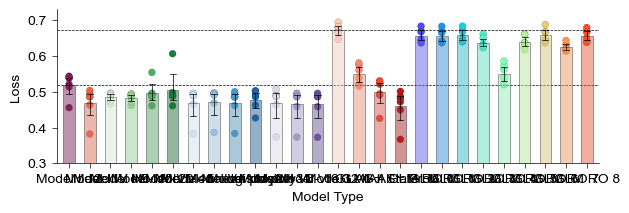

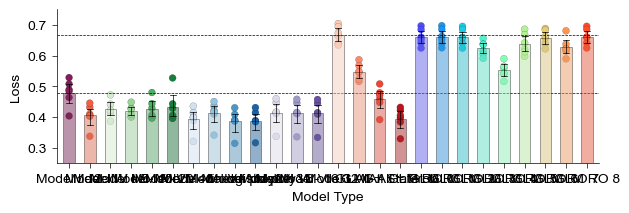

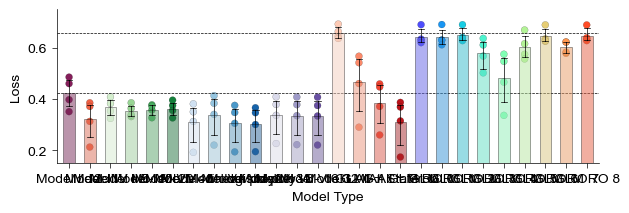

['G All + Prob' 'GLM RO 4' 'Model I - 1' 'Model I - 2' 'Model II'
 'Model IV - 10' 'Model V - linear' 'Model VI - 16']


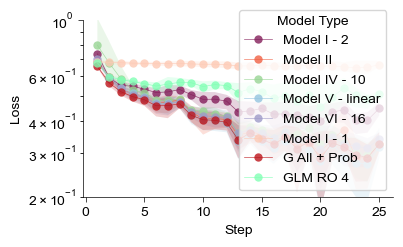

In [9]:
with open(join(figdata, f'{code_id} [Average].pkl'), 'rb') as handle:
    Data = pickle.load(handle)
    
ModelNames = ['Model I - 2', 
                  'Model II', #'Model III',
                  'Model IV - 5', 'Model IV - 10', 'Model IV - 20', 'Model IV - 40',
                  'Model V - linear', 'Model V - logistic', 'Model V - poly2', 'Model V - poly3',
                  'Model VI - 8', 'Model VI - 16', 'Model VI - 32']
    
ModelNames2 = ['Model I - 1', 'GLM All'] + ['G All + State', 'G All + Prob'] + [f'GLM RO {i}' for i in range(9)]

# Statistical test
stat_names = ModelNames + ModelNames2
print(np.unique(Data['Model Type']))
for i in [6, 12, 18]:
    mat = np.zeros((len(stat_names), len(stat_names)))
    SubData = SubDict(Data, Data.keys(), np.where(Data['Step'] == i)[0])
    for j in range(len(stat_names)-1):
        for k in range(j+1, len(stat_names)):
            idx0 = np.where(SubData['Model Type'] == stat_names[j])[0]
            idx1 = np.where(SubData['Model Type'] == stat_names[k])[0]
            mat[j, k] = ttest_rel(SubData['Loss'][idx0], SubData['Loss'][idx1])[1]
            mat[k, j] = mat[j, k]
    
    D = pd.DataFrame(mat, index=stat_names, columns=stat_names)
    D.to_excel(join(figdata, code_id+f'_loss_stat_step{i}.xlsx'), index=False)

idx = np.where(np.isin(Data['Model Type'], ModelNames+ModelNames2))[0]
Data = SubDict(Data, Data.keys(), idx)

def plot_decode_error(SubData, step, ylim: tuple[float, float]):
    a = np.mean(SubData['Loss'][SubData['Model Type'] == 'Model I - 1'])
    b = np.mean(SubData['Loss'][SubData['Model Type'] == 'Model I - 2'])
    fig = plt.figure(figsize=(7, 2))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.axhline(a, 0, 30, color='k', ls='--', linewidth=0.5)
    ax.axhline(b, 0, 30, color='k', ls='--', linewidth=0.5)
    sns.stripplot(
        x='Model Type',
        y='Loss',
        hue='Model Type',
        data=SubData,
        order=ModelNames + ModelNames2,
        hue_order=ModelNames + ModelNames2,
        palette=ModelPalette,
        edgecolor='black',
        linewidth=0.1,
        size=5,
        jitter=0,
        zorder=1
        #gap=0.3,
        #flierprops={'markersize': 1},
    )
    sns.barplot(
        x='Model Type',
        y='Loss',
        hue='Model Type',
        data=SubData,
        order=ModelNames + ModelNames2,
        hue_order=ModelNames + ModelNames2,
        palette=ModelPalette,
        edgecolor='black',
        linewidth=0.5,
        capsize=0.3,
        gap=0.3,
        alpha=0.5,
        err_kws={'linewidth': 0.5, 'color': 'k'},
        zorder=2
    )
    ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlim(-0.6, 25.6)
    plt.savefig(join(loc, f"step {step}.png"), dpi=600)
    plt.savefig(join(loc, f"step {step}.svg"), dpi=600)
    plt.show()
    
idx = np.where(Data['Step'] == 6)[0]
SubData = SubDict(Data, Data.keys(), idx)
plot_decode_error(SubData, 7, (0.3, 0.73))

idx = np.where(Data['Step'] == 12)[0]
SubData = SubDict(Data, Data.keys(), idx)
plot_decode_error(SubData, 13, (0.25, 0.75))

idx = np.where(Data['Step'] == 18)[0]
SubData = SubDict(Data, Data.keys(), idx)
plot_decode_error(SubData, 19, (0.15, 0.75))

ModelNames_Subset = [
    'Model I - 2', 
    'Model II', 
    'Model IV - 10', 
    'Model V - linear',
    'Model VI - 16',
    'Model I - 1',
    'G All + Prob',
    'GLM RO 4'
]
Color_Subset = [
    ModelPalette[0],
    ModelPalette[1],
    ModelPalette[3],
    ModelPalette[7],
    ModelPalette[11],
    ModelPalette[13], 
    ModelPalette[16],
    ModelPalette[21],
]
idx = np.where(np.isin(AvgLoss['Model Type'], ModelNames_Subset))[0]
SubData = SubDict(AvgLoss, AvgLoss.keys(), idx)
print(np.unique(SubData['Model Type']))
fig = plt.figure(figsize=(4, 2.3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.lineplot(
    x='Step',
    y='Loss',
    hue='Model Type',
    data=SubData,
    palette=Color_Subset,
    hue_order=ModelNames_Subset,
    linewidth=0.5,
    err_kws={'edgecolor': None},
    marker='o',
    markersize=6,
    alpha=0.8,
    markeredgewidth=0
)
ax.semilogy()
ax.set_ylim(0.2, 1)
plt.savefig(join(loc, "Loss with Sequence Lengths.png"), dpi=600)
plt.savefig(join(loc, "Loss with Sequence Lengths.svg"), dpi=600)
plt.show()